In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox

# handle filepaths
import os
import configparser

In [4]:

#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

## Load data

In [36]:
# get London borough shapefile
london = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\London_Borough_Excluding_MHW.shp'))
london = london.to_crs('EPSG:4326')

# convert to correct CRS to have units in meters in the UK
_crs = "EPSG:32630"
london_reprojected = london.to_crs(_crs)

### Get roads from OSM

In [42]:
road_stats = {"NAME": [],
              "street_length_total": [],
              "intersection_count": [],
              #"street_density_km":[]
              }

for i in range(len(london)):
    roads = ox.graph_from_polygon(london["geometry"][i],network_type='drive')
    basic_stats = ox.stats.basic_stats(roads, area=None)
    road_stats["NAME"].append(london["NAME"][i])
    #road_stats["area_size_skm"].append(london_reprojected["geometry"][i].area / 10**6)
    road_stats["street_length_total"].append(basic_stats["street_length_total"])
    road_stats["intersection_count"].append(basic_stats["intersection_count"])
   # road_stats["street_density_km"].append(basic_stats["street_density_km"]) #need to update osmnx for this
    
road_stats_df = pd.DataFrame.from_dict(road_stats)
road_stats_df.head()

### Get cycle routes from OSM

Note: This seems to be outdated now --> Useful code found in [this tutorial](https://williamthyer.github.io/posts/2021/4/bike_networks/) and the [original Github Thread](https://github.com/gboeing/osmnx/issues/151)

Example notebooks in docs: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/08-custom-filters-infrastructure.ipynb

In [102]:
cf = '["highway"~"cycleway"]'
place = "Amsterdam, Netherlands"
G = ox.graph_from_place(place, network_type='bike', simplify=False, custom_filter=cf)

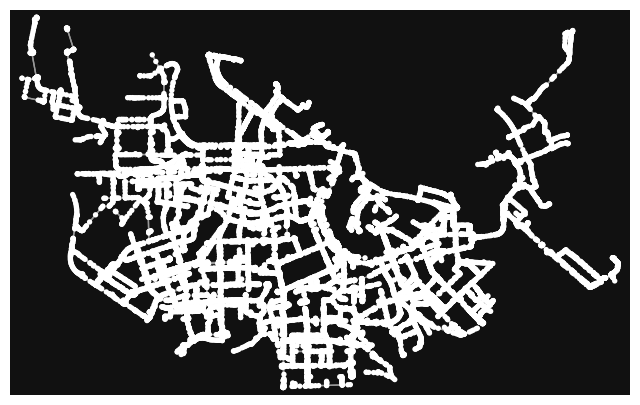

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [103]:
ox.plot_graph(G)

### Get TfL cycle routes

In [68]:
# load TFL cycle routes
cycle_routes = gpd.GeoDataFrame.from_file('TfL_CycleRoutes.json')

# reprojected to metric crs
cycle_routes_reprojected = cycle_routes.to_crs(london_reprojected.crs)

# calculate length (m) per borough
cycle_routes_length_total = []

for i in range(len(london_reprojected)):
    routes_clipped = gpd.clip(cycle_routes_reprojected, london_reprojected["geometry"][i], keep_geom_type=True)
    cycle_routes_length_total.append(routes_clipped["geometry"].length.sum())

london_reprojected["TfL_cycle_routes_length_total"] = cycle_routes_length_total

### Merge and process data

In [88]:
# merge data sets
df = london_reprojected
df = pd.merge(df, road_stats_df, left_on="NAME", right_on="NAME", how="left")

In [ ]:
# calculate cycle routes ratio of total street network
df["TfL_cycle_ratio"] = df["TfL_cycle_routes_length_total"] / df["street_length_total"]

In [105]:
df.to_csv("df_interim_output.csv")

ImportError: cannot import name 'SequenceNotStr' from 'pandas._typing' (c:\Users\lisa.hornung\anaconda3\envs\py3_ox\lib\site-packages\pandas\_typing.py)